In [1]:
# Author : Evangelos Papoutsellis STFC, February 2022
# Contact : https://epapoutsellis.github.io/

# Import libraries
from cil.framework import  AcquisitionGeometry
from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator, MatrixOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cil.plugins.astra.utilities import convert_geometry_to_astra
from cil.optimisation.functions import TotalVariation, IndicatorBox
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.plugins import TomoPhantom

import matplotlib.pyplot as plt

from cvxpy import *
import astra

import numpy as np

Below we solve the Totalvariation Tomography reconstruction problem 
with non-negativity constraint using the Primal-Dual Hybrid algorithm for the following datasets:

* Relatively small tomophantom data
* Real data : [Rock-Data](https://github.com/TomographicImaging/Paper-2021-RSTA-CIL-Part-II).
* Simulated CIL data

We compare different formulations of the PDHG algorithm for the TV tomography problem:

* Explicit: Each proximal step has an exact solution
* Implicit (FGP_TV): Inner TV step is solved using the FGP_TV algorithm from the CCPi-Regularisation toolkit
* Implicit (CIL_TV): Inner TV step is solved using the FGP_TV algorithm from the CCPi-Regularisation toolkit
* Implicit (FGP_TV/CIL_TV) Accelerated: We make TV strongly convex and use the primal acceleration of PDHG
* Explicit (Rescale) : The Projection and the Gradient operator are rescaled.
* Implicit (Rescale) : The Projection is rescaled.
* Implicit (Rescale FGP_TV/CIL_TV) Accelerated: We make TV strongly convex and use the primal acceleration of PDHG


# Case I: Tomophantom

### Create AcquisitionGeometry, ImageGeometry, ProjectionOperator

In [2]:
# Detectors
N = 128
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, 0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

### Simulate noisy data

/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


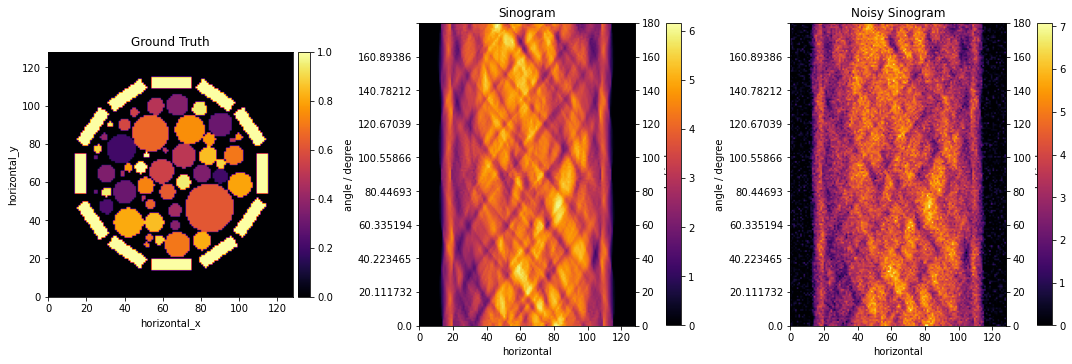

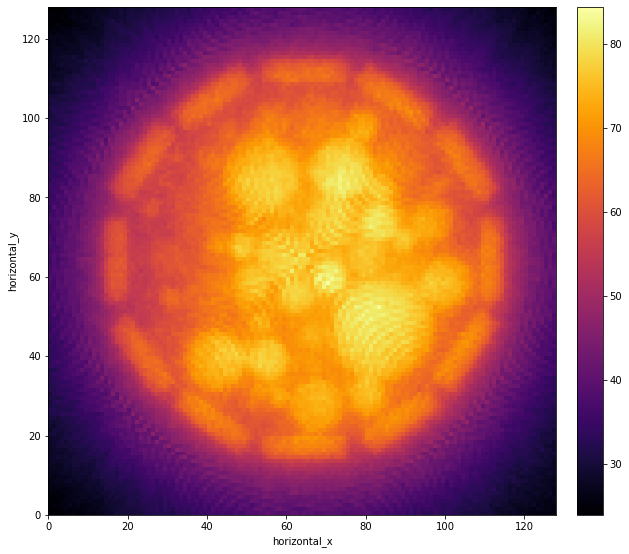

In [3]:
# Get phantom
# phantom = dataexample.SIMPLE_PHANTOM_2D.get(size=(N, N))
phantom = TomoPhantom.get_ImageData(12, ig)

# Create an acquisition data
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

np.random.seed(10)

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], 
       title = ['Ground Truth','Sinogram','Noisy Sinogram'], 
       num_cols=3, cmap = 'inferno')

show2D(A.adjoint(noisy_sino), cmap="inferno")

### Check Astra matrix with ProjectionOperator of CIL

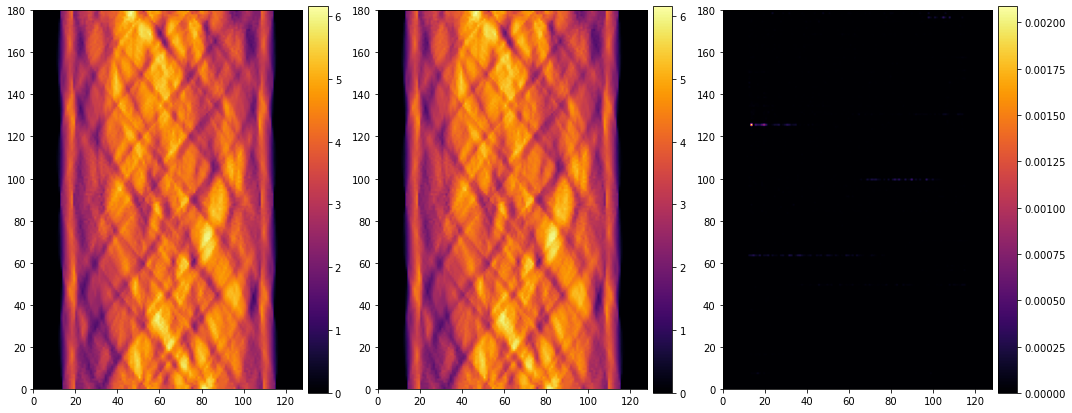

Norm of A_cil = 14.848070403326771
Norm of astra mat = 14.848070197924518


In [4]:
# convert to astra geometries
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

# projection id
proj_id = astra.create_projector('line', ag_astra, ig_astra)

# matrix id
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)

sino_astra = (W*phantom.array.flatten()).reshape((len(ag.angles), N))

#show
show2D([sino_astra, sino.array, np.abs(sino.array-sino_astra)], num_cols=3, cmap="inferno")

print("Norm of A_cil = {}".format(A.norm()))

mat_cil = MatrixOperator(W.T*W)

print("Norm of astra mat = {}".format(np.sqrt(mat_cil.norm())))



### TV regularisation parameter

In [5]:
alpha = 1.5

### Solve with cvxpy. If MOSEK is not installed use SCS

In [6]:
N, M = ig.shape
u_cvx = Variable(N*M)
fidelity = sum_squares(W@u_cvx.flatten() - noisy_sino.array.flatten())
constraints = [u_cvx>=0]

regulariser = (alpha/ig.voxel_size_x) * tv(reshape(u_cvx, (N,M))) 
obj =  Minimize( fidelity + regulariser)
prob = Problem(obj, constraints)

res = prob.solve(solver = MOSEK, verbose = True)
# res = prob.solve(solver = SCS, verbose = True, eps=1e-3)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) May 14 10:20:10 AM: Your problem has 16384 variables, 1 constraints, and 0 parameters.
(CVXPY) May 14 10:20:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 14 10:20:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 14 10:20:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 14 10:20:10 AM: Compiling problem (target solver=MOSEK).
(CVXPY) May 14 10:20:10 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

### Edit the update_objective_interval method in order to compute distance from the _true_ solution

In [7]:
def update_objective_with_error(self):
    """
    Evaluates the primal objective, the dual objective and the primal-dual gap.
    """

    self.operator.direct(self.x_old, out=self.y_tmp)
    f_eval_p = self.f(self.y_tmp)
    g_eval_p = self.g(self.x_old)
    p1 = f_eval_p + g_eval_p

    self.operator.adjoint(self.y, out=self.x_tmp)
    self.x_tmp.multiply(-1.0, out=self.x_tmp)

    f_eval_d = self.f.convex_conjugate(self.y)
    g_eval_d = self.g.convex_conjugate(self.x_tmp)
    d1 = f_eval_d + g_eval_d
        
    if self.computer_error_image:
        # computer error from the true solution
        tmp = (self.x - self.true).norm()/self.true.norm()
        self.loss.append([p1, -d1, p1+d1, tmp])
    else:
        self.loss.append([p1, -d1, p1+d1])
        
    
PDHG.update_objective = update_objective_with_error

true_tmp = ig.allocate()
true_tmp.fill(u_cvx.value.reshape(ig.shape))
PDHG.true = true_tmp

PDHG.computer_error_image = True

### Solve with PDHG explicit

In [8]:
Grad = GradientOperator(ig)
f2 = alpha * MixedL21Norm()
f1 = L2NormSquared(b=noisy_sino)
F = BlockFunction(f1, f2)
K = BlockOperator(A, Grad)
G = IndicatorBox(lower=0.0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

pdhg_explicit= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_explicit.run(verbose=0)


PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: divide by zero encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


### Solve with Implicit PDHG (FGP_TV & CIL_TV)

In [9]:
K = A
F = L2NormSquared(b=noisy_sino)
G = (alpha/ig.voxel_size_x)*FGP_TV(max_iteration=100,tolerance=0, device="gpu")

normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg_implicit_fgp_tv = PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_fgp_tv.run(verbose=0)


# use TotalVariation from CIL
G = alpha * TotalVariation(max_iteration=100, tolerance=0)

# Setup and run PDHG
pdhg_implicit_cil_tv= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_cil_tv.run(verbose=0)

PDHG setting up
PDHG configured
PDHG setting up
PDHG configured


### Solve with Implicit PDHG (FGP_TV & CIL_TV): TV is gamma-strongly convex. Use primal acceleration in PDHG

In [10]:
gamma = 0.05

gamma1 = gamma

G = (alpha/ig.voxel_size_x)*FGP_TV(max_iteration=100,tolerance=0, device="gpu", strong_convexity_constant=gamma1)

pdhg_implicit_primal_acc_fgp_tv= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1, gamma_g=gamma1 )
pdhg_implicit_primal_acc_fgp_tv.run(verbose=0)

gamma2 = gamma

G = alpha * TotalVariation(max_iteration=100, tolerance=0, strong_convexity_constant=gamma2)
pdhg_implicit_primal_acc_cil_tv= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1, gamma_g=gamma2 )
pdhg_implicit_primal_acc_cil_tv.run(verbose=0)


PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:362: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 0.05 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))


PDHG setting up
PDHG configured


### Convergence Plots

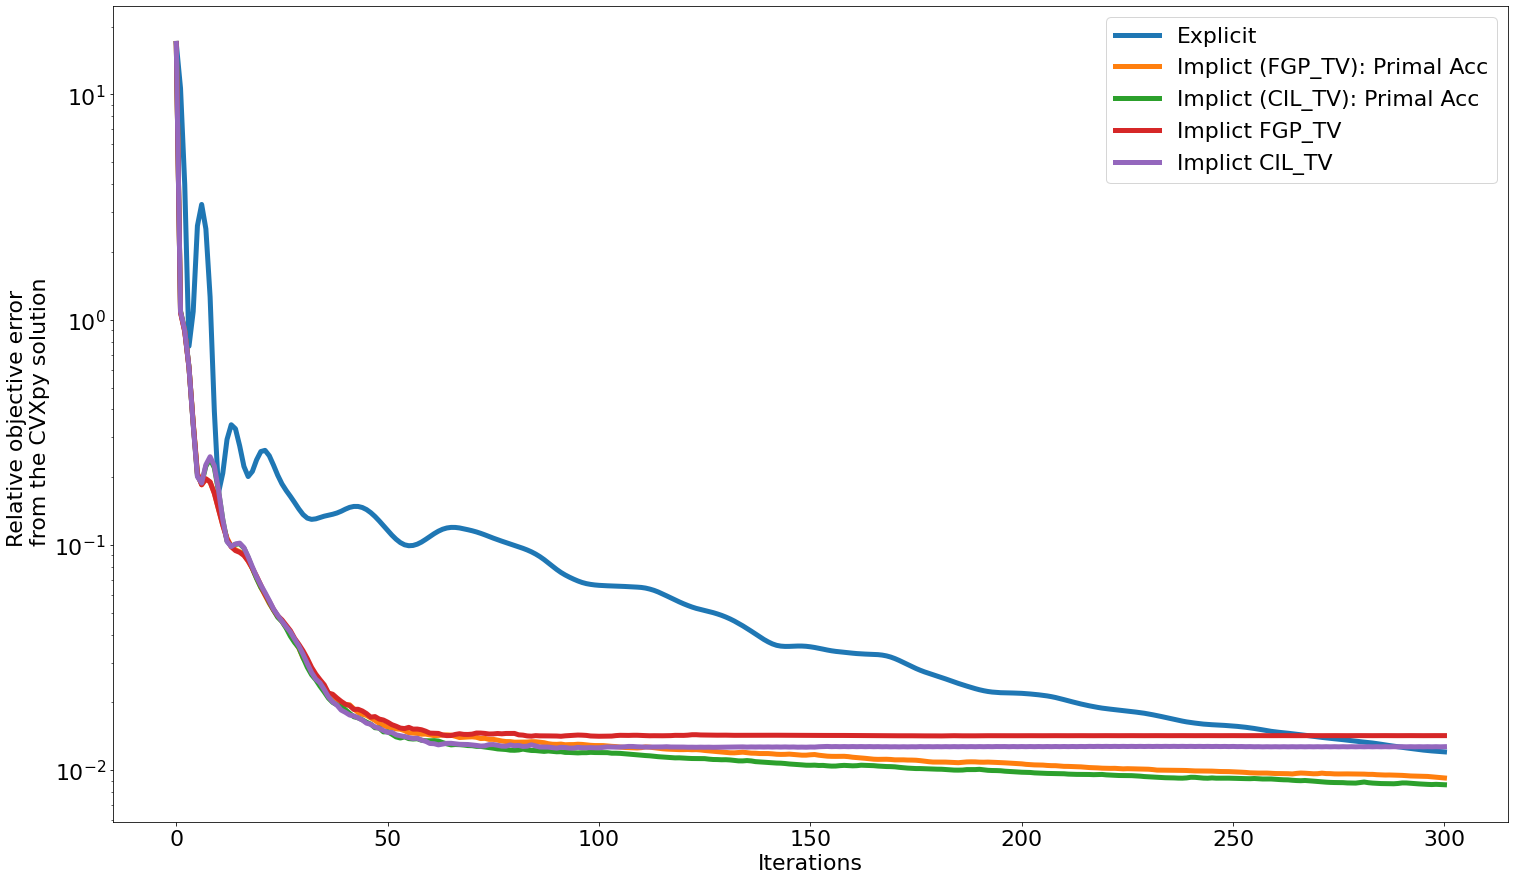

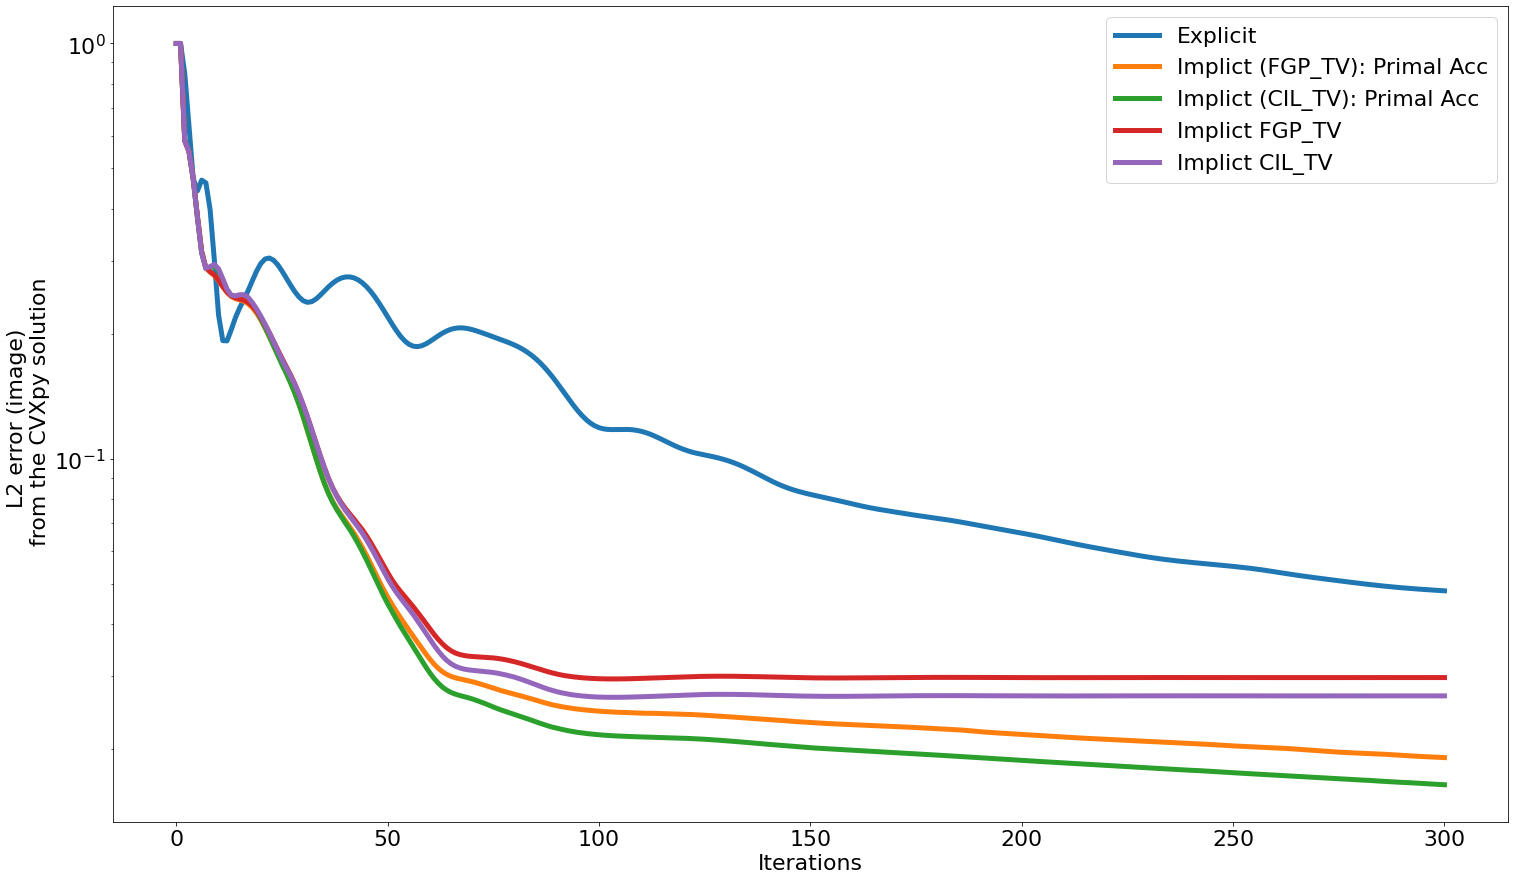

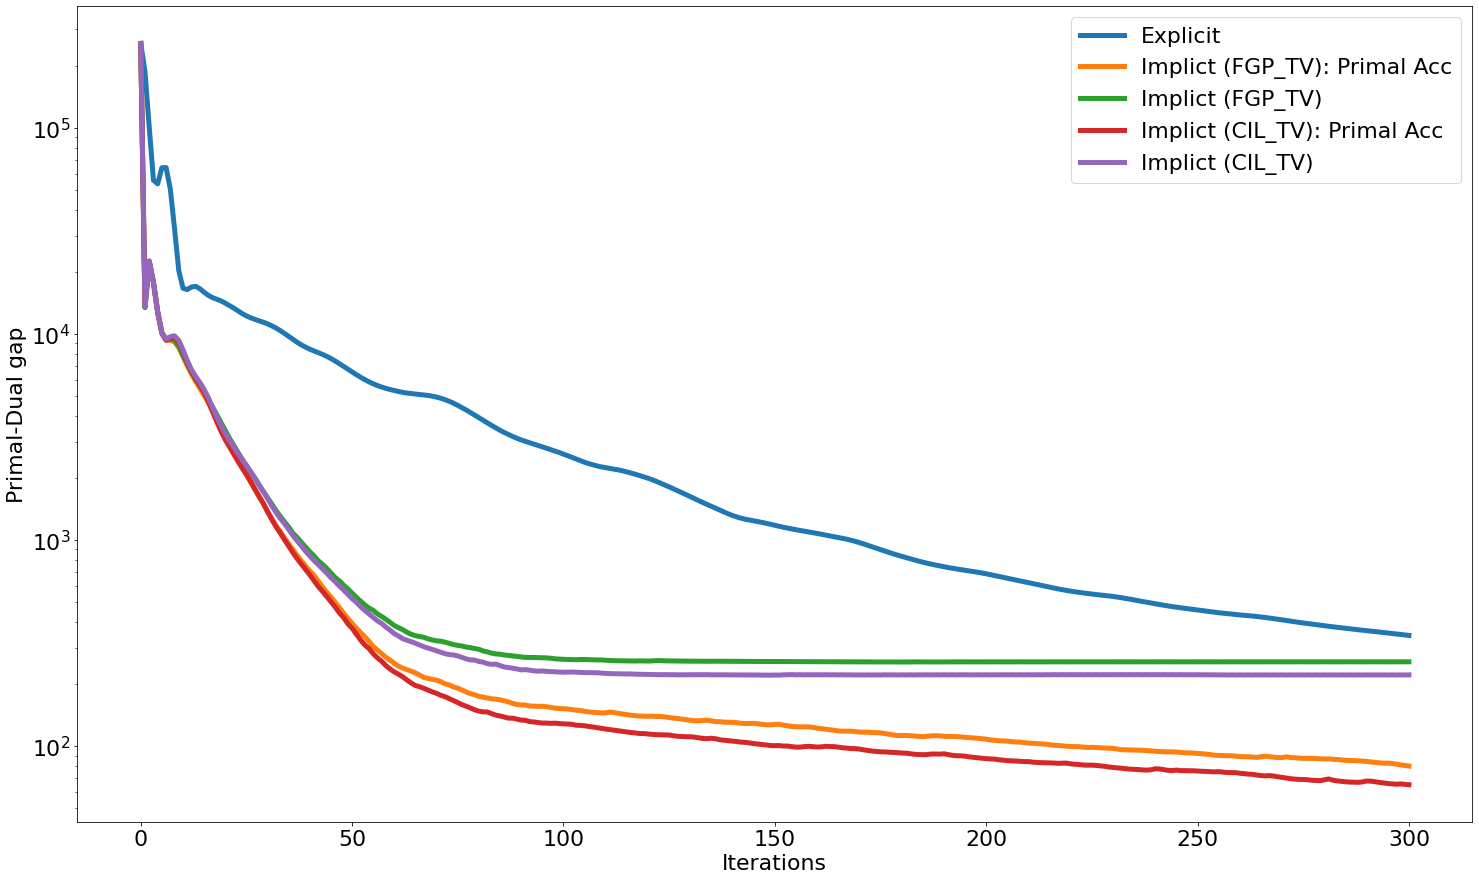

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22, 'lines.linewidth': 5.})

plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_explicit.objective - obj.value)/obj.value, label = "Explicit")
plt.semilogy( np.abs(pdhg_implicit_primal_acc_fgp_tv.objective - obj.value)/obj.value, label = "Implict (FGP_TV): Primal Acc")
plt.semilogy( np.abs(pdhg_implicit_primal_acc_cil_tv.objective - obj.value)/obj.value, label = "Implict (CIL_TV): Primal Acc")
plt.semilogy( np.abs(pdhg_implicit_fgp_tv.objective - obj.value)/obj.value, label = "Implict FGP_TV")
plt.semilogy( np.abs(pdhg_implicit_cil_tv.objective - obj.value)/obj.value, label = "Implict CIL_TV")
plt.legend()
plt.ylabel("Relative objective error \n from the CVXpy solution")
plt.xlabel("Iterations")
plt.show()


plt.figure(figsize=(25,15))
plt.semilogy( [x[3] for x in pdhg_explicit.loss], label = "Explicit")
plt.semilogy( [x[3] for x in pdhg_implicit_primal_acc_fgp_tv.loss],label = "Implict (FGP_TV): Primal Acc")
plt.semilogy( [x[3] for x in pdhg_implicit_primal_acc_cil_tv.loss], label = "Implict (CIL_TV): Primal Acc")
plt.semilogy( [x[3] for x in pdhg_implicit_fgp_tv.loss], label = "Implict FGP_TV")
plt.semilogy( [x[3] for x in pdhg_implicit_cil_tv.loss], label = "Implict CIL_TV")
plt.legend()
plt.ylabel("L2 error (image) \n from the CVXpy solution")
plt.xlabel("Iterations")
plt.show()


plt.figure(figsize=(25,15))
plt.semilogy( pdhg_explicit.primal_dual_gap, label = "Explicit")
plt.semilogy( pdhg_implicit_primal_acc_fgp_tv.primal_dual_gap, label = "Implict (FGP_TV): Primal Acc")
plt.semilogy( pdhg_implicit_fgp_tv.primal_dual_gap, label = "Implict (FGP_TV)")
plt.semilogy( pdhg_implicit_primal_acc_cil_tv.primal_dual_gap, label = "Implict (CIL_TV): Primal Acc")
plt.semilogy( pdhg_implicit_cil_tv.primal_dual_gap, label = "Implict (CIL_TV)")
plt.legend()
plt.ylabel("Primal-Dual gap")
plt.xlabel("Iterations")
plt.show()


### Show objectives

In [12]:
print("CVX objective = {}".format(obj.value))
print("Explicit objective = {}".format(pdhg_explicit.objective[-1]))
print("Implicit (FGP_TV) objective = {}".format(pdhg_implicit_fgp_tv.objective[-1]))
print("Implicit (CIL_TV) objective = {}".format(pdhg_implicit_cil_tv.objective[-1]))
print("Implicit-acce (FGP_TV) objective = {}".format(pdhg_implicit_primal_acc_fgp_tv.objective[-1]))
print("Implicit-acce (CIL_TV) objective = {}".format(pdhg_implicit_primal_acc_cil_tv.objective[-1]))

CVX objective = 14381.956483773627
Explicit objective = 14555.54833984375
Implicit (FGP_TV) objective = 14586.90625
Implicit (CIL_TV) objective = 14564.974853515625
Implicit-acce (FGP_TV) objective = 14514.909704589843
Implicit-acce (CIL_TV) objective = 14506.017889404297


### Show reconstructions

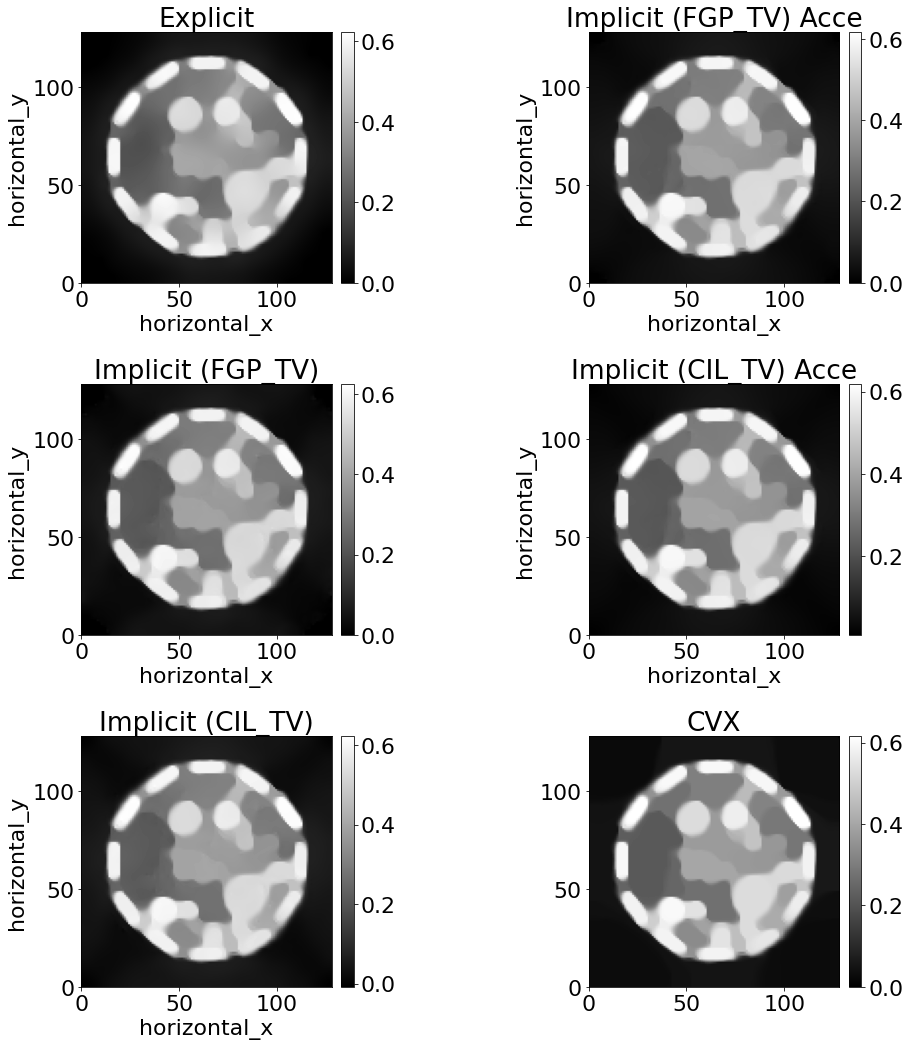

In [13]:
res_cvx = u_cvx.value.reshape(N,N)
show2D([pdhg_explicit.solution, 
        pdhg_implicit_primal_acc_fgp_tv.solution, 
        pdhg_implicit_fgp_tv.solution, 
        pdhg_implicit_primal_acc_cil_tv.solution, 
        pdhg_implicit_cil_tv.solution,         
        res_cvx],
        title=['Explicit', 
               'Implicit (FGP_TV) Acce', 
               'Implicit (FGP_TV)',
               'Implicit (CIL_TV) Acce', 
               'Implicit (CIL_TV)',               
               'CVX'], num_cols=2)

### Absolute difference from _true_ solution (cvxpy)

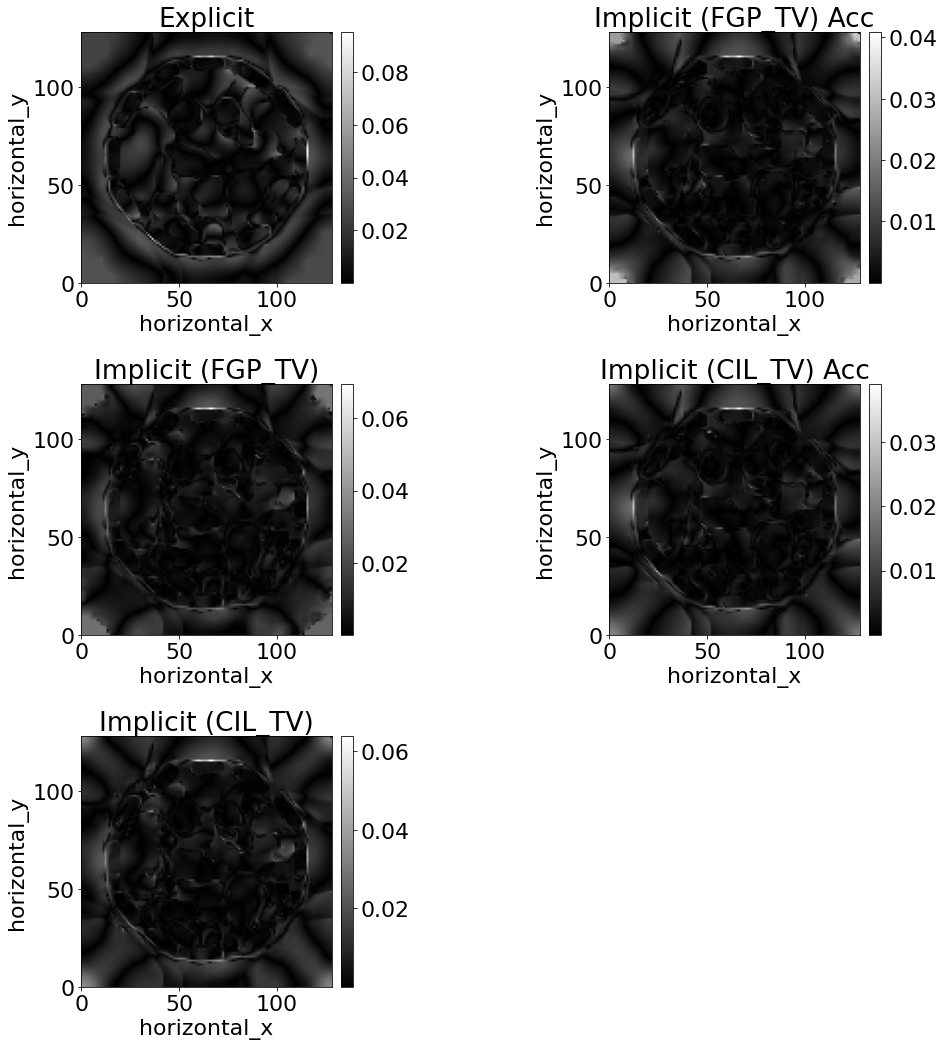

In [14]:
show2D([(pdhg_explicit.solution - res_cvx).abs(), 
        (pdhg_implicit_primal_acc_fgp_tv.solution - res_cvx).abs(),
        (pdhg_implicit_fgp_tv.solution - res_cvx).abs(),
        (pdhg_implicit_primal_acc_cil_tv.solution - res_cvx).abs(),
        (pdhg_implicit_cil_tv.solution - res_cvx).abs()],
        title=['Explicit', 
               'Implicit (FGP_TV) Acc', 
               'Implicit (FGP_TV)',
               'Implicit (CIL_TV) Acc', 
               'Implicit (CIL_TV)'], 
               num_cols=2)

# Case II: Real Data (Rock) CIL2 paper

### Read data and get a 2D slice

In [15]:
from cil.io import NEXUSDataReader, NEXUSDataWriter
from cil.processors import Slicer

name = "data_after_ring_remover_318_398.nxs"
read_data = NEXUSDataReader(file_name = "/media/newhd/shared/ReproducePapers/CIL2/Case_Study_MultispectralTomography/" + name)
tmp_data = read_data.load_data()


2D Cone-beam tomography
System configuration:
	Source position: [    0.    , -4307.6924]
	Rotation axis position: [0., 0.]
	Detector position: [    0.   , 12260.355]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [400   1]
	Pixel size: [0.25 0.25]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 120
	Angles 0-20 in radians:
[ 0.7853982 ,  0.7325983 ,  0.6797984 ,  0.62699854,  0.57419866,
  0.5213988 ,  0.4685989 ,  0.41579902,  0.36299914,  0.31019926,
  0.2573994 ,  0.20459951,  0.15179965,  0.09899977,  0.04619989,
 -0.00659998, -0.05939986, -0.11219974, -0.16499962, -0.21779948]



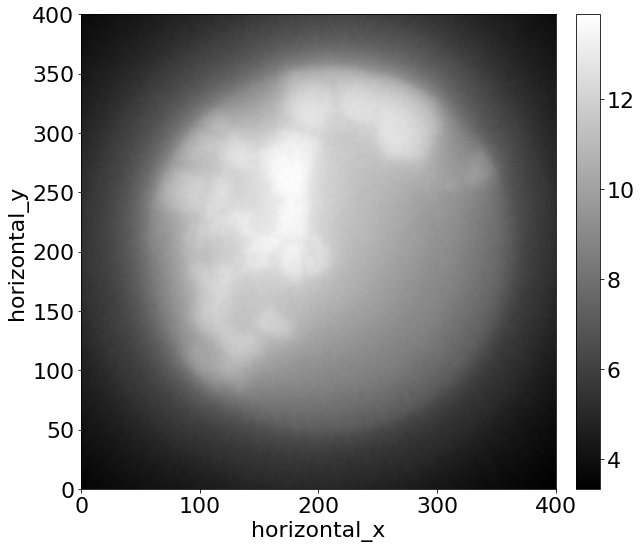

In [16]:
data = Slicer(roi={'channel': (18,23)})(tmp_data)
data2D = data.get_slice(channel=3, vertical="centre")
ag = data2D.geometry
print(ag)
ig = ag.get_ImageGeometry()
A = ProjectionOperator(ig, ag, device="gpu")
show2D(A.adjoint(data2D))

### Explicit PDHG

In [17]:
alpha = 0.01
Grad = GradientOperator(ig)
f2 = alpha * MixedL21Norm()
f1 = 0.5*L2NormSquared(b=data2D)
F = BlockFunction(f1, f2)
K = BlockOperator(A, Grad)
G = IndicatorBox(lower=0.0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

PDHG.computer_error_image = False
pdhg_explicit= PDHG(f = F, g = G, operator = K, 
            max_iteration = 5000, sigma=sigma, tau=tau,
            update_objective_interval = 1 )
pdhg_explicit.run(verbose=0)

PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: divide by zero encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


### Implicit PDHG (with FGP_TV)

In [18]:
K = A
F = 0.5*L2NormSquared(b=data2D)
G = (alpha/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu")

normK = K.norm()
sigma = 1/normK
tau = 1./normK


PDHG.computer_error_image = True
PDHG.true = pdhg_explicit.solution

# Setup and run PDHG
pdhg_implicit= PDHG(f = F, g = G, operator = K, 
            max_iteration = 500, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit.run(verbose=0)


PDHG setting up
PDHG configured


### Solve with Implicit PDHG (with FGP_TV): TV is gamma-strongly convex. Use primal acceleration in PDHG

In [19]:
gamma = 0.01

gamma1 = gamma

G = (alpha/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu", strong_convexity_constant=gamma1)

# Setup and run PDHG
pdhg_implicit_primal_acc = PDHG(f = F, g = G, operator = K, 
            max_iteration = 500, sigma=sigma, tau=tau,
            update_objective_interval = 1, gamma_g=gamma1 )
pdhg_implicit_primal_acc.run(verbose=0)

# save_algo_metadata(pdhg,name)

PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:362: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 0.01 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))


### Convergence Plots

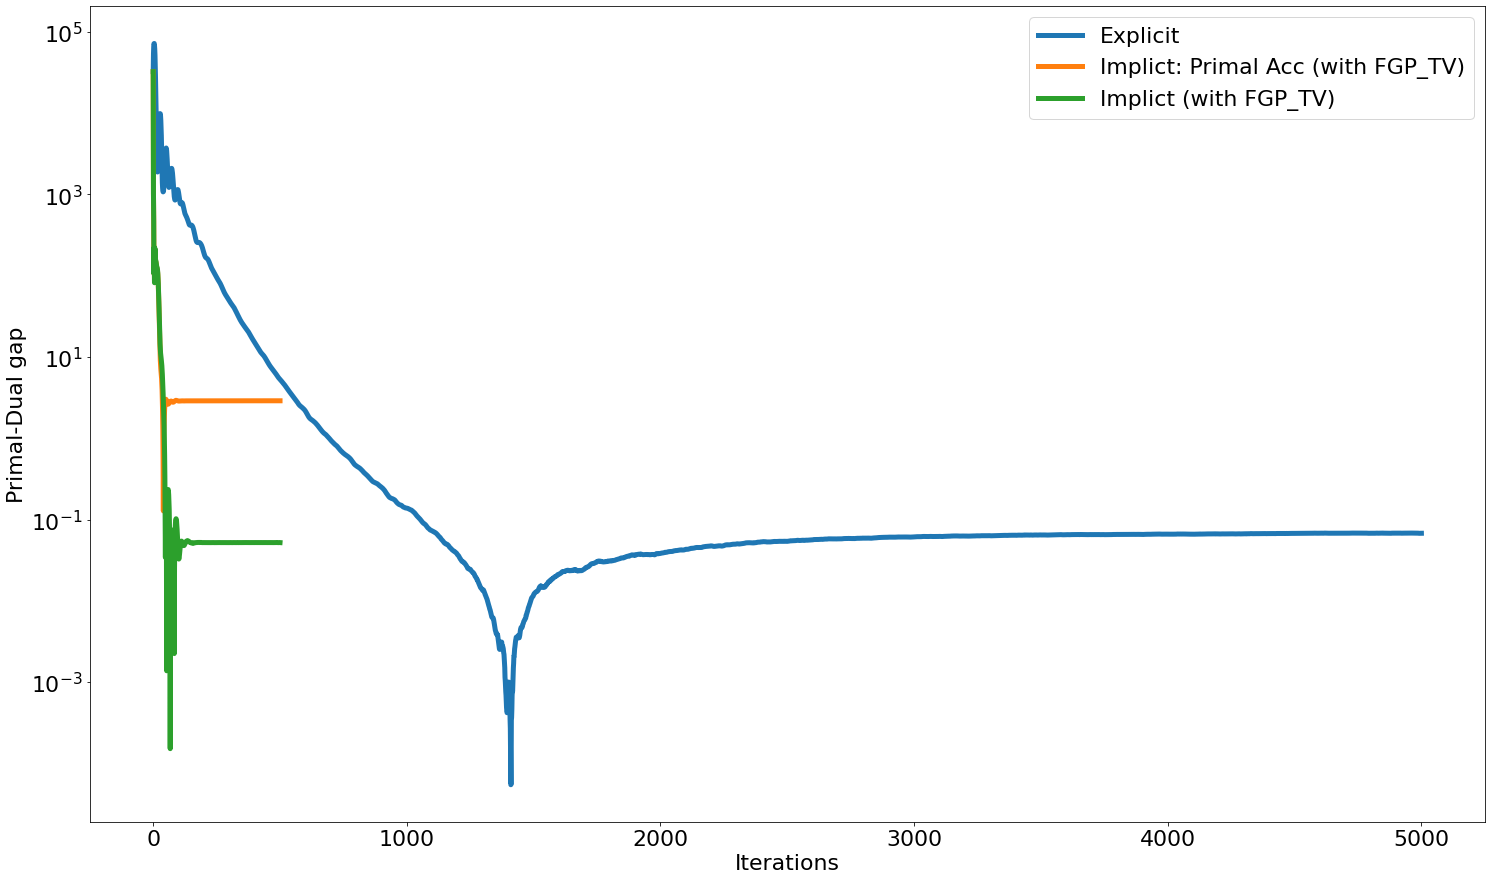

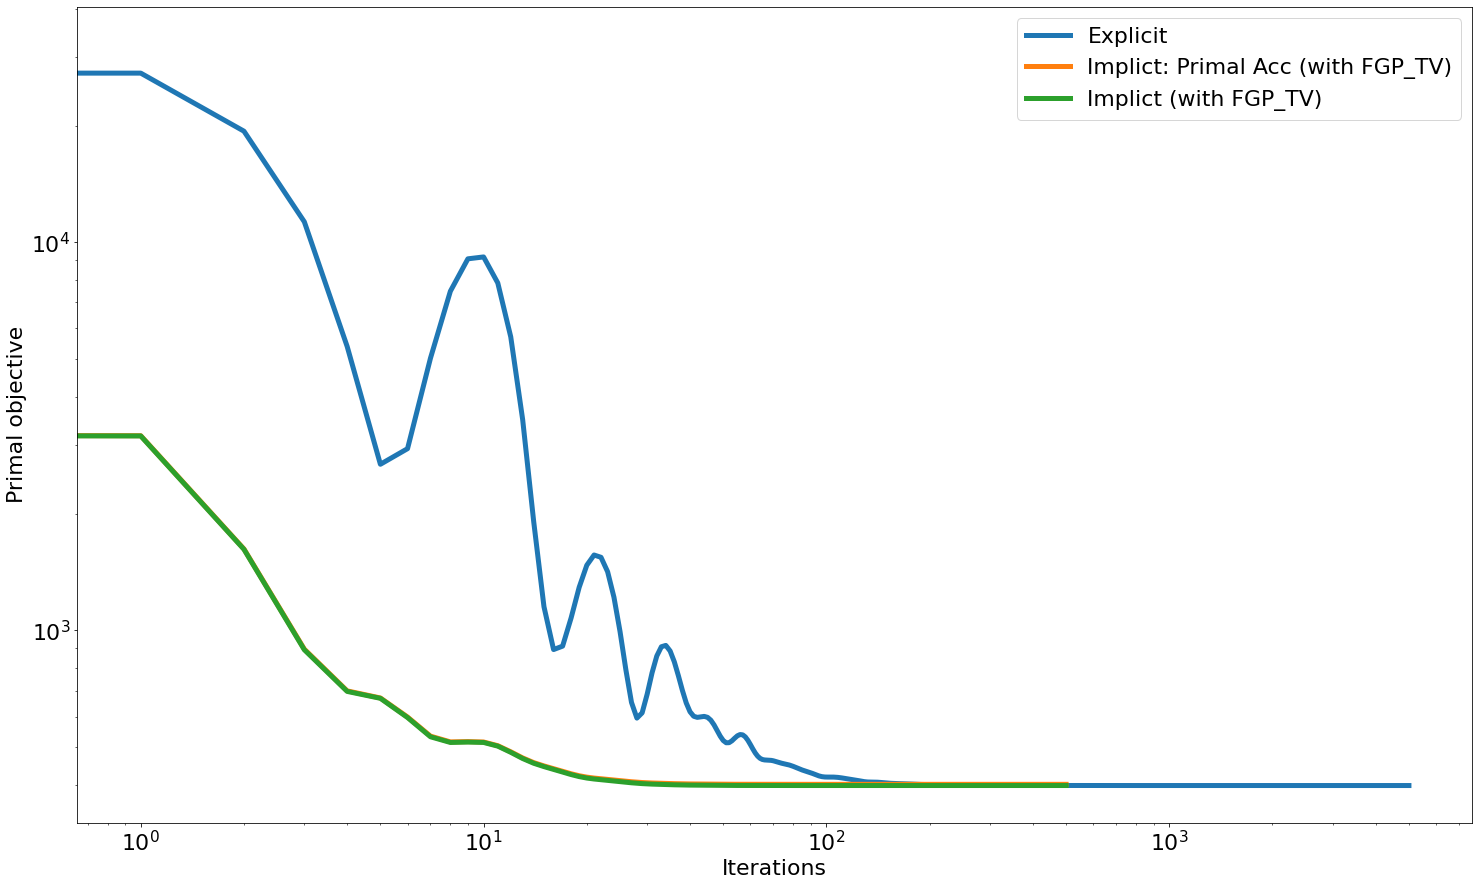

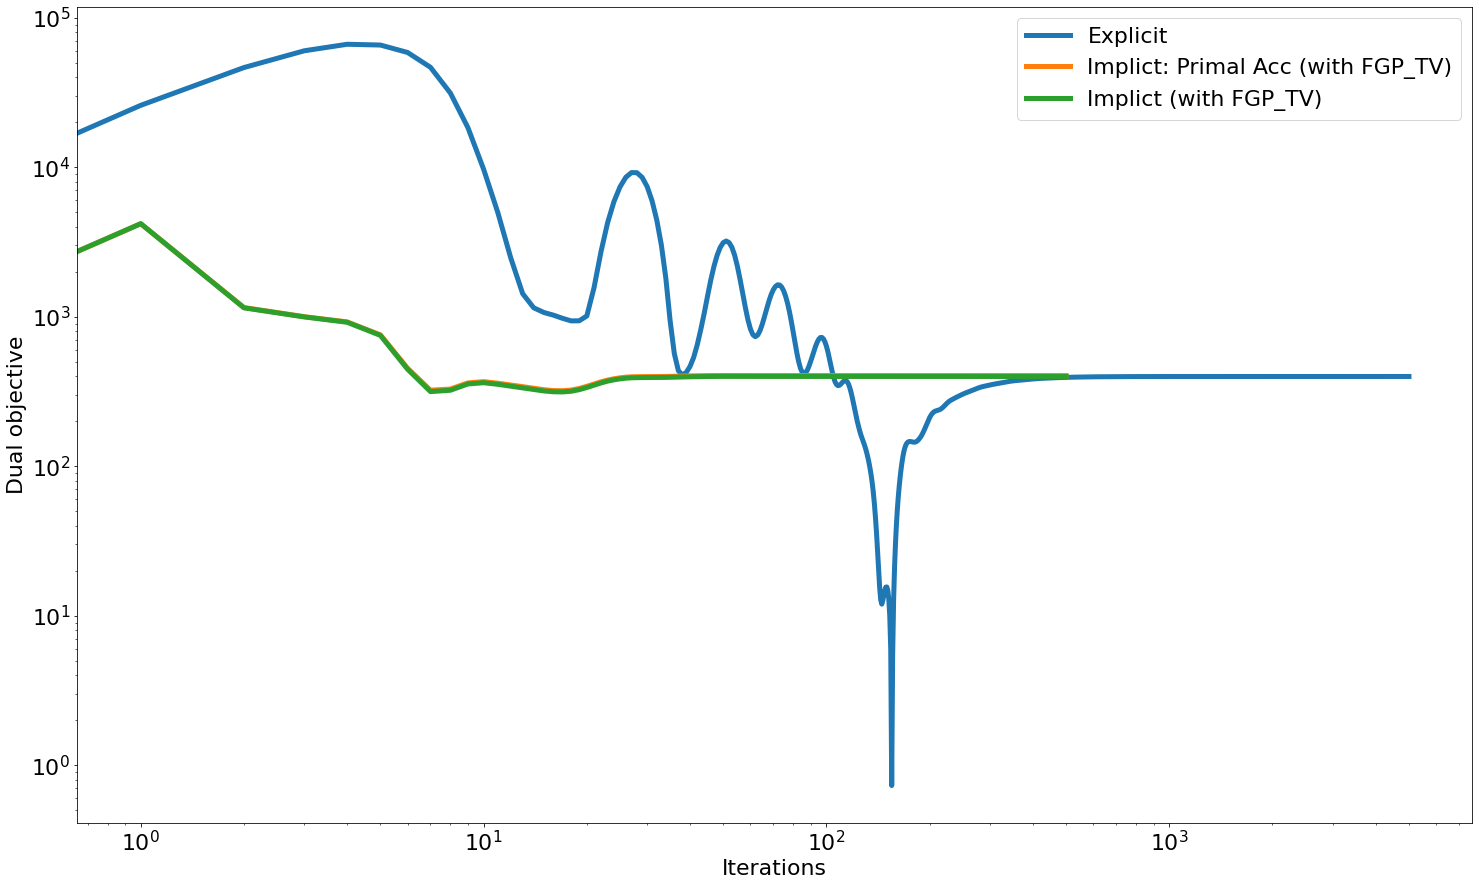

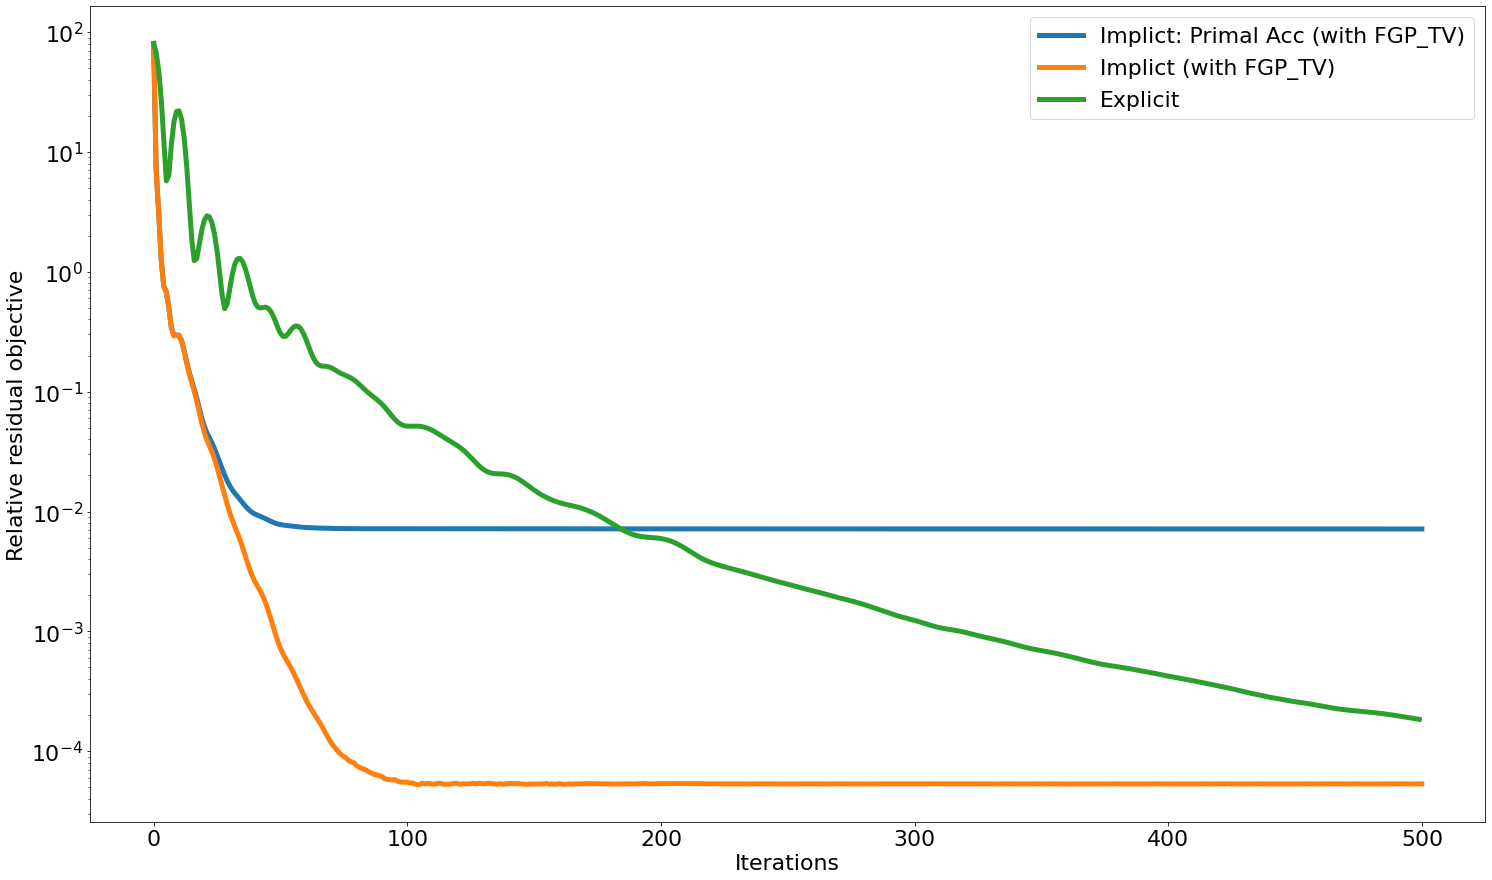

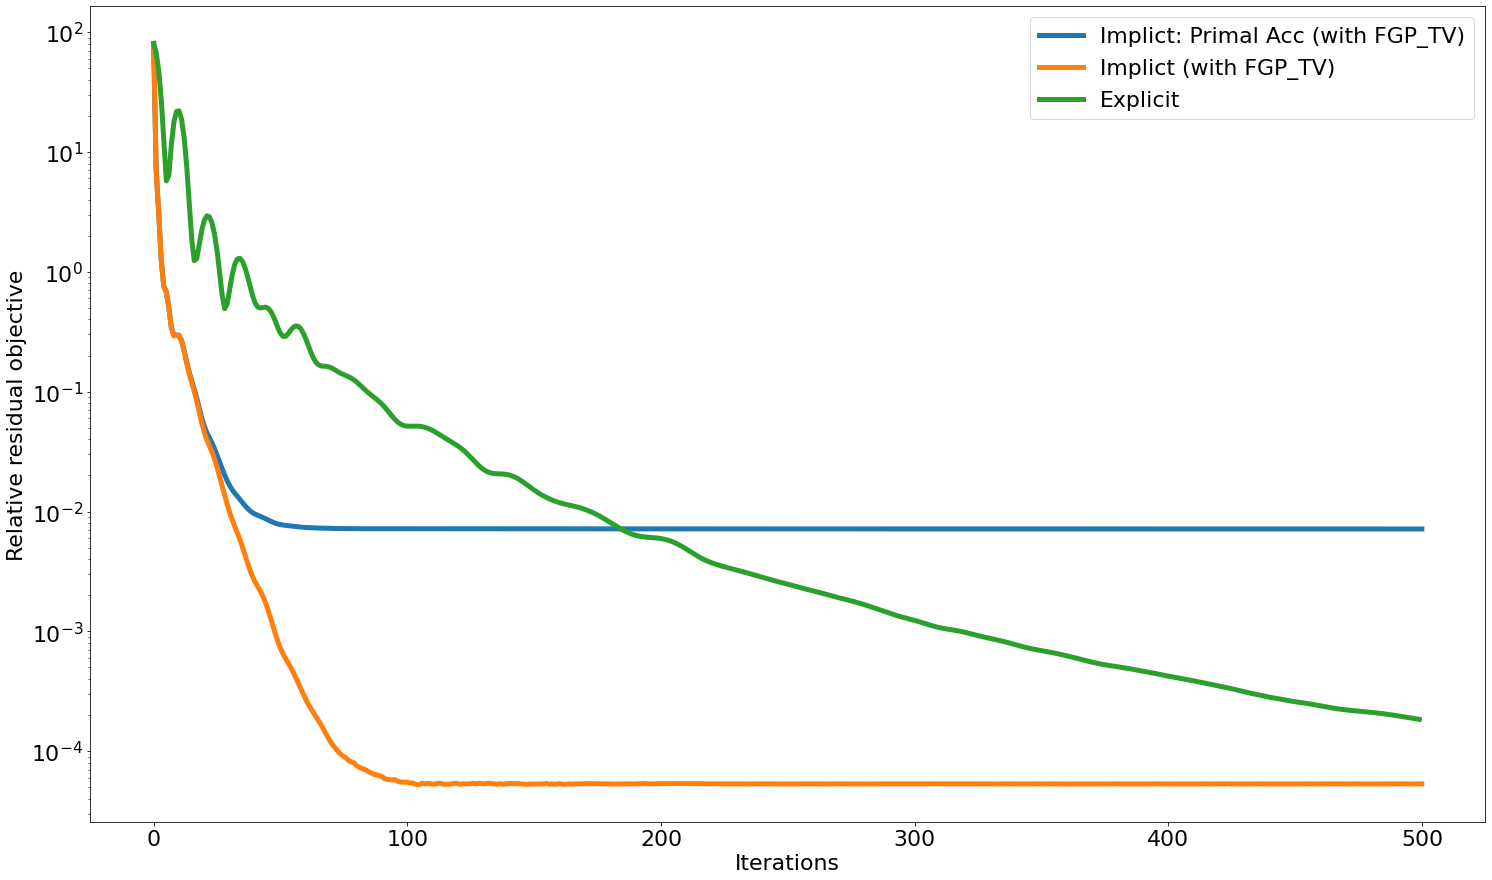

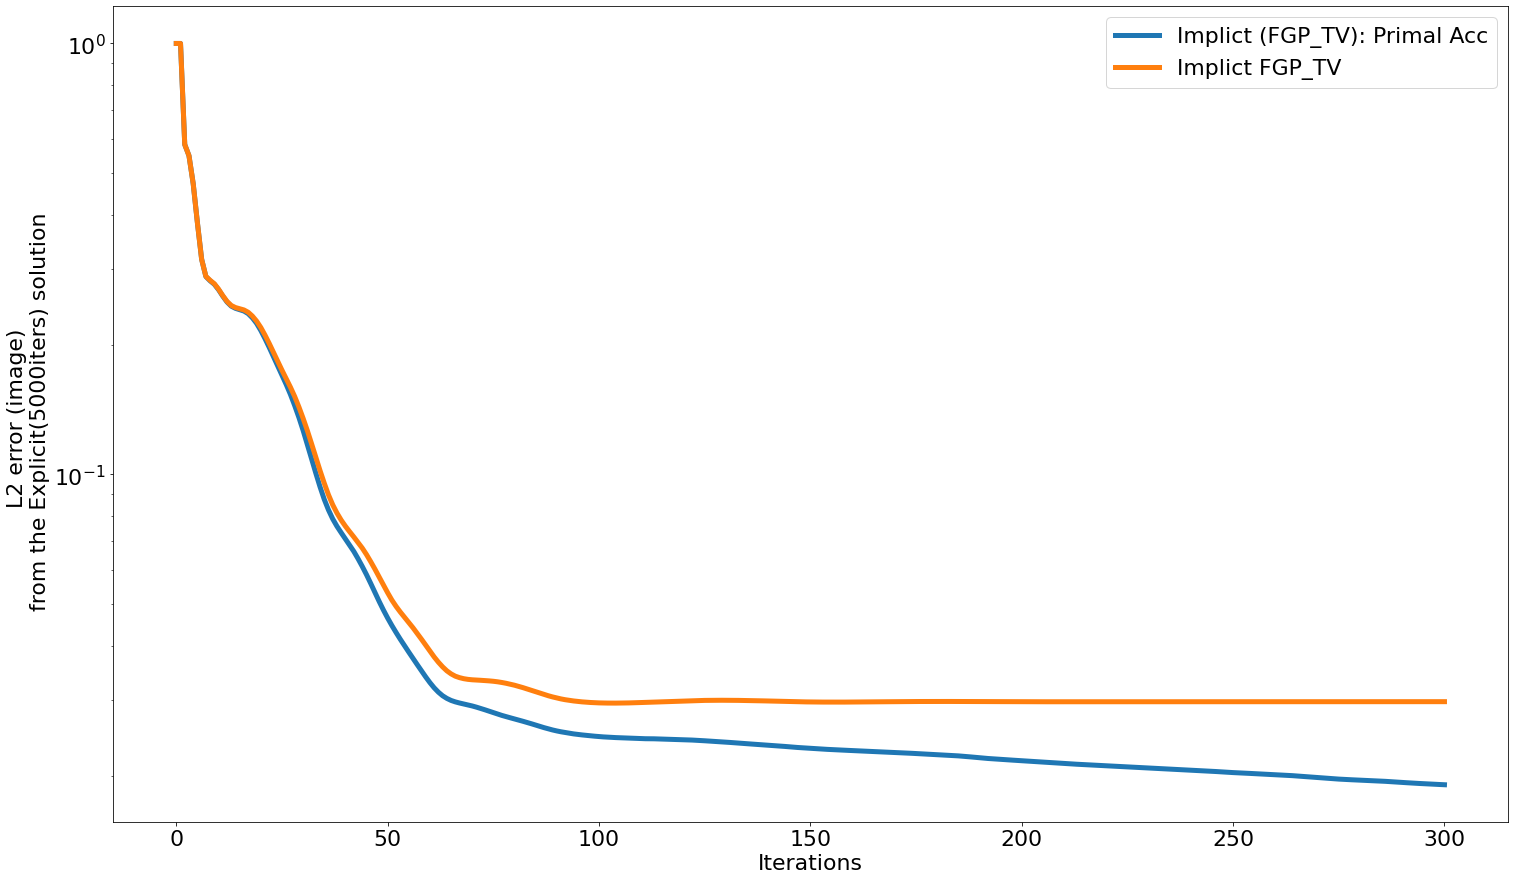

In [20]:
# pdgap
plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_explicit.primal_dual_gap), label = "Explicit")
plt.semilogy( np.abs(pdhg_implicit_primal_acc.primal_dual_gap), label = "Implict: Primal Acc (with FGP_TV)")
plt.semilogy( np.abs(pdhg_implicit.primal_dual_gap), label = "Implict (with FGP_TV)")
plt.legend()
plt.ylabel("Primal-Dual gap")
plt.xlabel("Iterations")
plt.show()

# primal objective
plt.figure(figsize=(25,15))
plt.loglog( pdhg_explicit.objective, label = "Explicit")
plt.loglog( pdhg_implicit_primal_acc.objective, label = "Implict: Primal Acc (with FGP_TV)")
plt.loglog( pdhg_implicit.objective, label = "Implict (with FGP_TV)")
plt.legend()
plt.ylabel("Primal objective")
plt.xlabel("Iterations")
plt.show()

# dual objective
plt.figure(figsize=(25,15))
plt.loglog( np.abs(pdhg_explicit.dual_objective), label = "Explicit")
plt.loglog( np.abs(pdhg_implicit_primal_acc.dual_objective), label = "Implict: Primal Acc (with FGP_TV)")
plt.loglog( np.abs(pdhg_implicit.dual_objective), label = "Implict (with FGP_TV)")
plt.legend()
plt.ylabel("Dual objective")
plt.xlabel("Iterations")
plt.show()

# relative residual objective
plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_implicit_primal_acc.objective - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Implict: Primal Acc (with FGP_TV)")
plt.semilogy( np.abs(pdhg_implicit.objective - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Implict (with FGP_TV)")
plt.semilogy( np.abs(pdhg_explicit.objective[0:500] - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Explicit")
plt.legend()
plt.ylabel("Relative residual objective")
plt.xlabel("Iterations")
plt.show()

# relative image objective
plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_implicit_primal_acc.objective - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Implict: Primal Acc (with FGP_TV)")
plt.semilogy( np.abs(pdhg_implicit.objective - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Implict (with FGP_TV)")
plt.semilogy( np.abs(pdhg_explicit.objective[0:500] - pdhg_explicit.objective[-1])/pdhg_explicit.objective[-1], label = "Explicit")
plt.legend()
plt.ylabel("Relative residual objective")
plt.xlabel("Iterations")
plt.show()


plt.figure(figsize=(25,15))
plt.semilogy( [x[3] for x in pdhg_implicit_primal_acc_fgp_tv.loss],label = "Implict (FGP_TV): Primal Acc")
plt.semilogy( [x[3] for x in pdhg_implicit_fgp_tv.loss], label = "Implict FGP_TV")
plt.legend()
plt.ylabel("L2 error (image) \n from the Explicit(5000iters) solution")
plt.xlabel("Iterations")
plt.show()


### Show objectives (with FGP_TV)

In [21]:
print("Explicit objective = {}".format(pdhg_explicit.objective[-1]))
print("Implicit objective = {}".format(pdhg_implicit.objective[-1]))
print("Implicit-acce objective = {}".format(pdhg_implicit_primal_acc.objective[-1]))



Explicit objective = 398.47037109375003
Implicit objective = 398.4916763305664
Implicit-acce objective = 401.3196607971191


### Show reconstructions (with FGP_TV)

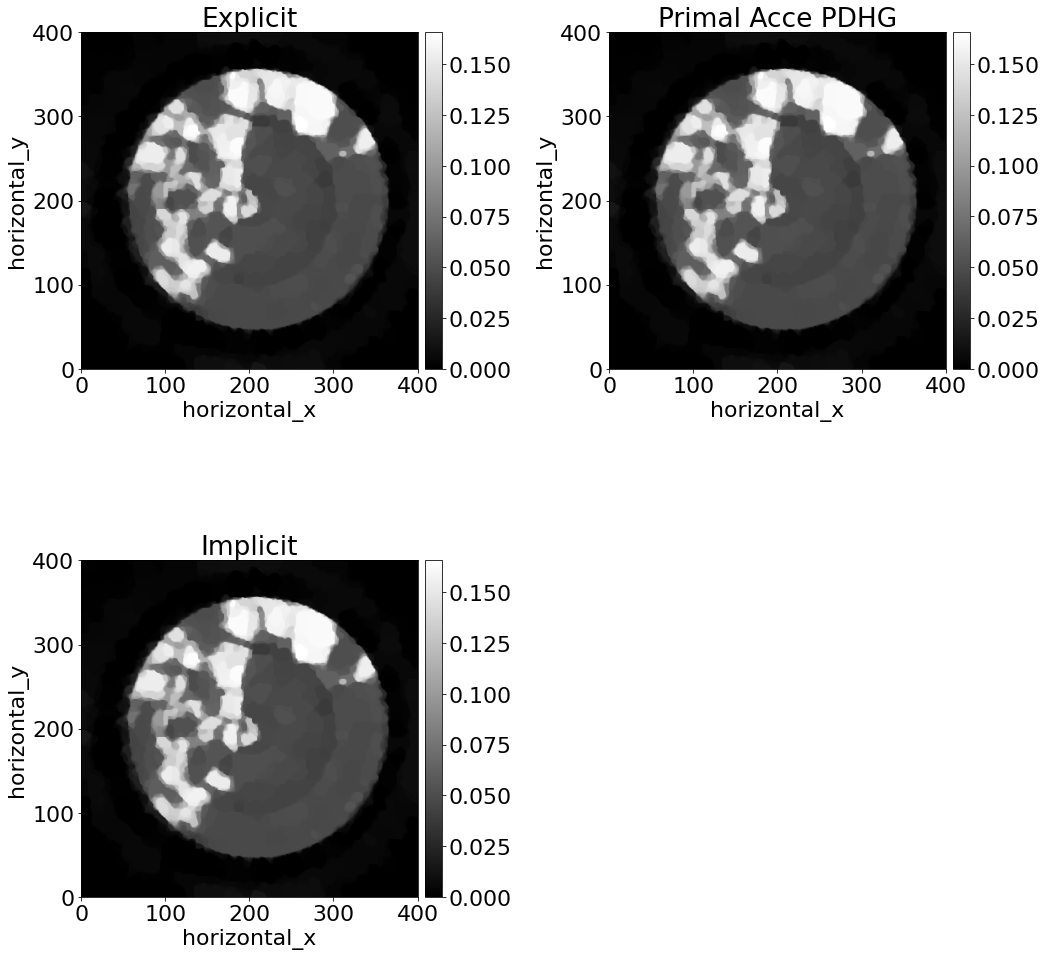

In [22]:
show2D([pdhg_explicit.solution, pdhg_implicit_primal_acc.solution, 
        pdhg_implicit.solution],
        title=['Explicit', 'Primal Acce PDHG', 
               'Implicit'], num_cols=2)

# Case III: Simulated data from CIL

In [23]:
from cil.utilities import dataexample
from cil.processors import TransmissionAbsorptionConverter

In [24]:
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()
print(data.geometry)

tmp_data = TransmissionAbsorptionConverter()(data)
tmp_data.reorder('astra')


data2D = tmp_data.get_slice(vertical='centre')

print(data2D)

ag = data2D.geometry
ig = ag.get_ImageGeometry()


3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [128 128]
	Pixel size: [16. 16.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 300
	Angles 0-20 in degrees:
[ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. , 13.2,
 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8]

Number of dimensions: 2
Shape: (300, 128)
Axis labels: ('angle', 'horizontal')



In [25]:
alpha = 300

A = ProjectionOperator(ig, ag, device="gpu")
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

f2 = alpha*MixedL21Norm()
f1 = L2NormSquared(b=data2D)
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0.0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

PDHG.computer_error_image = False
pdhg_explicit_no_rescale= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_explicit_no_rescale.run(verbose=0)

PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: divide by zero encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/framework/framework.py:2421: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


### Solve the rescaled problem

Rescale both the ProjectionOperator and the GradientOperator. 

$$\|K\| = \sqrt{2}$$

In [26]:
Anorm = A.norm()
Gradnorm = Grad.norm()

# explicit
Grad = GradientOperator(ig)
f2 = (alpha/Anorm**2) * MixedL21Norm()
f1 = (1/Gradnorm)*L2NormSquared(b=data2D/Anorm)
K = BlockOperator((1./Anorm)*A, (1./Gradnorm)*Grad)

normK = K.norm()

F = BlockFunction(f1, f2)
G = IndicatorBox(lower=0.0)

sigma = 1./normK
tau = 1./normK
print(sigma,tau)

pdhg_explicit_rescale= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_explicit_rescale.run(verbose=0)


0.7072374053838527 0.7072374053838527
PDHG setting up
PDHG configured


### Implicit PDHG

In [27]:
# implicit

K = A
F = L2NormSquared(b=data2D)
G = (alpha/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu")

normK = K.norm()
sigma = 1/normK
tau = 1./normK

PDHG.computer_error_image = False

# Setup and run PDHG
pdhg_implicit= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit.run(verbose=0)


PDHG setting up
PDHG configured


### Implicit PDHG with primal acceleration

In [28]:
# implicit primal acc
gamma = 10.

gamma1 = gamma

G = (alpha/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu", strong_convexity_constant=gamma1)

# Setup and run PDHG
pdhg_implicit_primal_acc = PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1, gamma_g=gamma1 )
pdhg_implicit_primal_acc.run(verbose=0)


PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:362: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 10.0 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))


### Implicit PDHG Rescaled

In [29]:
# implicit rescale

K = (1./Anorm)*A
F = L2NormSquared(b=data2D/Anorm)
G = (alpha/Anorm**2/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu")

normK = K.norm()
sigma = 1/normK
tau = 1./normK

# Setup and run PDHG
pdhg_implicit_rescale= PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_rescale.run(verbose=0)


PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:435: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")


### Implicit PDHG (Rescale) with primal acceleration

In [30]:
# implicit primal acc
gamma = 5e2

gamma1 = gamma/Anorm**2

G = (alpha/Anorm**2/ig.voxel_size_x) * FGP_TV(max_iteration=200,tolerance=0, device="gpu", strong_convexity_constant=gamma1)

# Setup and run PDHG
pdhg_implicit_primal_acc_rescale = PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1, gamma_g=gamma1 )
pdhg_implicit_primal_acc_rescale.run(verbose=0)


PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:362: UserWarning: Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = 5.317006295760815e-05 is the correct strongly convex constant for g. 
  warnings.warn("Primal Acceleration of PDHG: The function g is assumed to be strongly convex with positive parameter `gamma_g`. You need to be sure that gamma_g = {} is the correct strongly convex constant for g. ".format(self.gamma_g))


### Convergence Plots - Show reconstructions

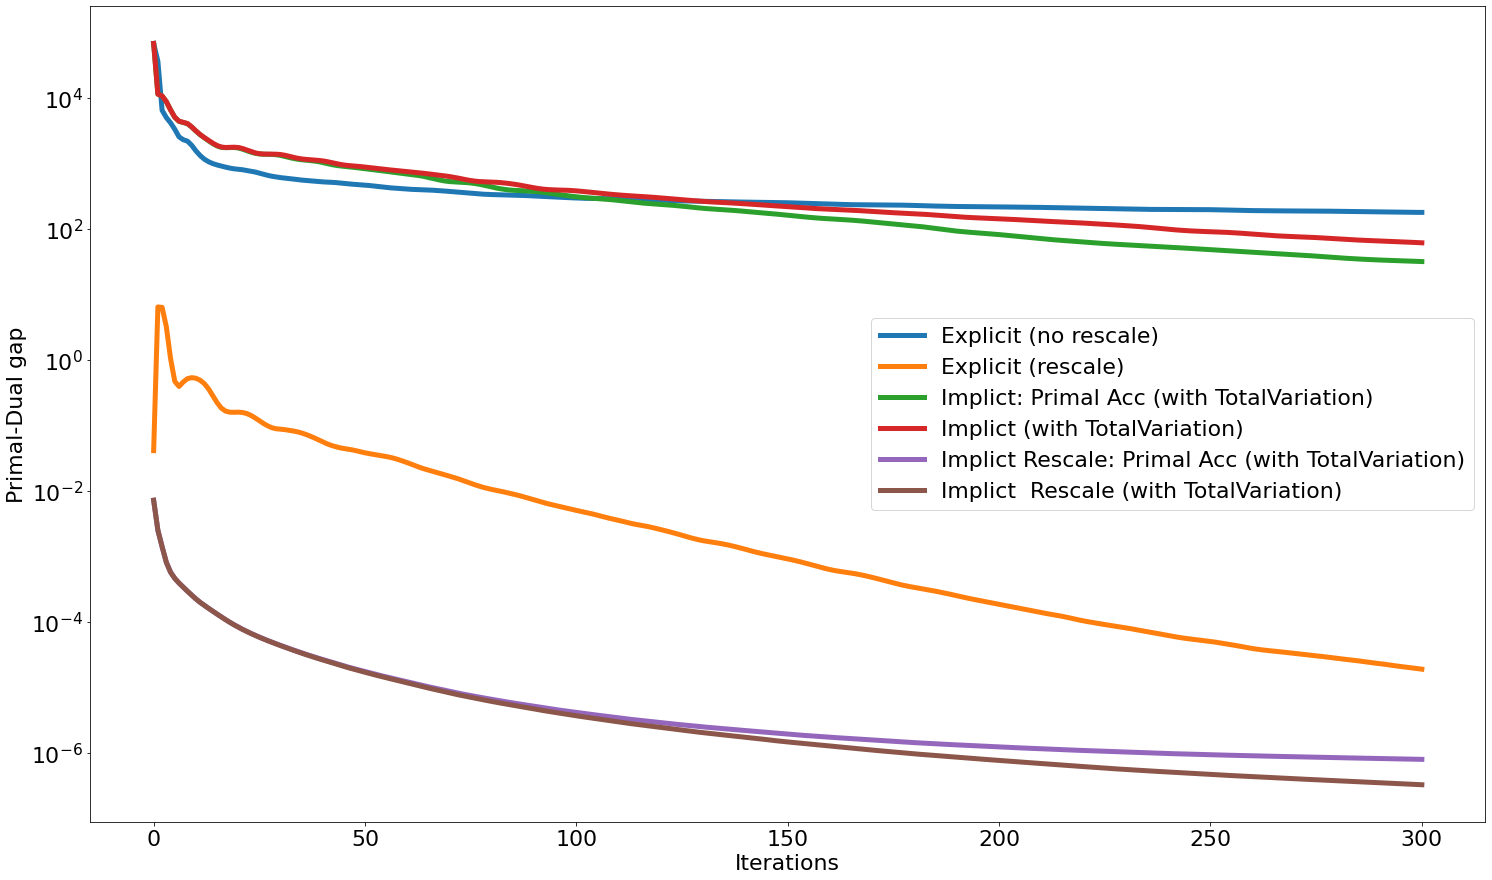

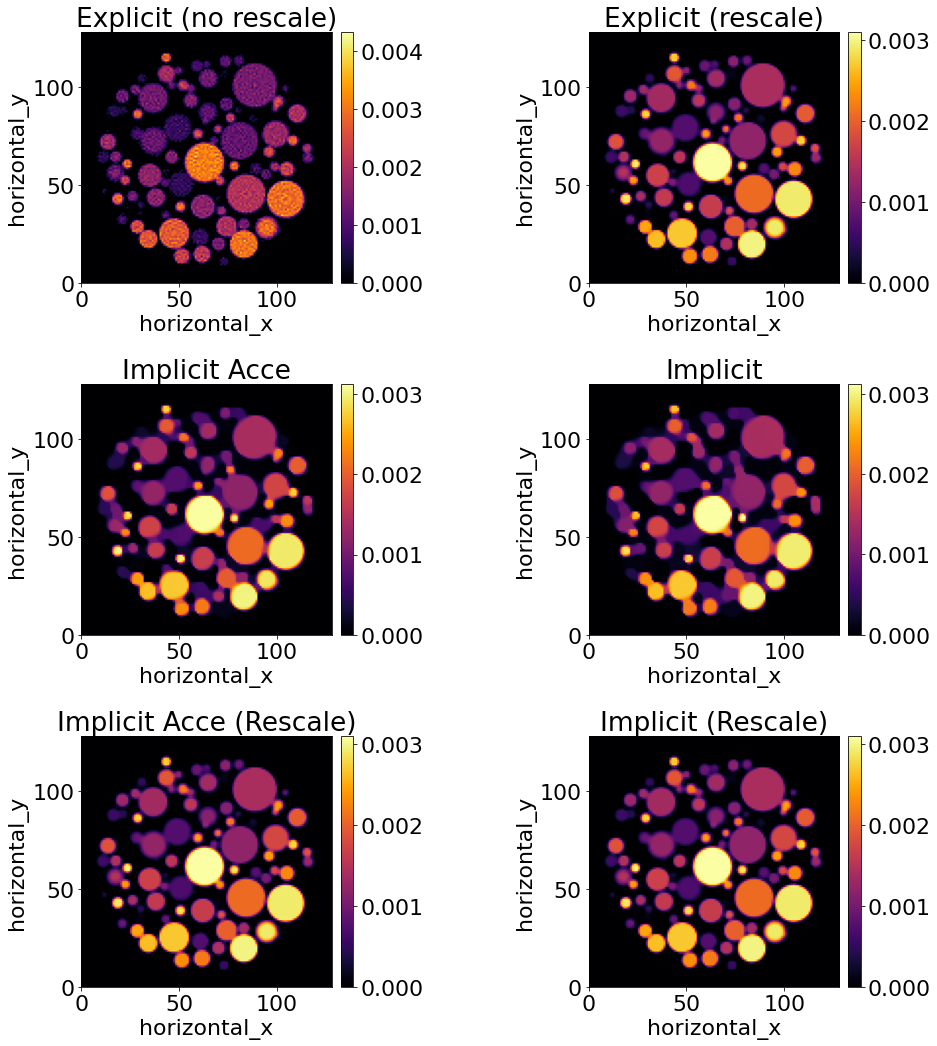

In [31]:

plt.rcParams.update({'font.size': 22, 'lines.linewidth': 5.})

plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_explicit_no_rescale.primal_dual_gap), label = "Explicit (no rescale)")
plt.semilogy( np.abs(pdhg_explicit_rescale.primal_dual_gap), label = "Explicit (rescale)")
plt.semilogy( np.abs(pdhg_implicit_primal_acc.primal_dual_gap), label = "Implict: Primal Acc (with TotalVariation)")
plt.semilogy( np.abs(pdhg_implicit.primal_dual_gap), label = "Implict (with TotalVariation)")
plt.semilogy( np.abs(pdhg_implicit_primal_acc_rescale.primal_dual_gap), label = "Implict Rescale: Primal Acc (with TotalVariation)")
plt.semilogy( np.abs(pdhg_implicit_rescale.primal_dual_gap), label = "Implict  Rescale (with TotalVariation)")
plt.legend()
plt.ylabel("Primal-Dual gap")
plt.xlabel("Iterations")
plt.show()

show2D([pdhg_explicit_no_rescale.solution, 
        pdhg_explicit_rescale.solution, 
        pdhg_implicit_primal_acc.solution, 
        pdhg_implicit.solution,
        pdhg_implicit_primal_acc_rescale.solution, 
        pdhg_implicit_rescale.solution],
        title=['Explicit (no rescale)', 
               'Explicit (rescale)', 
               'Implicit Acce', 
               'Implicit',
               'Implicit Acce (Rescale)', 
               'Implicit (Rescale)'], num_cols=2, cmap="inferno")



### Remark

In the implicit cases where the inner problem is solved using an iterative algorithm, i.e., `FISTA` algorithm on the `dual` TV denoising problem, **no warm start** is applied. Faster convergence can be obtained once [PR1201](https://github.com/TomographicImaging/CIL/pull/1201) is approved and this demo should be updated. A Draft demo comparing warm vs no-warm start can be found [here](https://github.com/epapoutsellis/CIL_work/blob/master/TotalVariation_warm_nowarm_Tomography.ipynb).

